### Final Project in Bayesian Data Analysis
# Bayesian hierarchical model for the prediction of football results


### Data preparation

In [1]:
#Import stuff
import pystan
import pylab as plt
import numpy as np
from bs4 import BeautifulSoup
import urllib.request
import pickle
from psis import psisloo

In [2]:
#Get data
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

y1 = data['home_goals']
y2 = data['away_goals']
home_teams = data['home_team']
away_teams = data['away_team']
g = np.arange(1,len(y1)+1)
ordered_teams = list(set(home_teams))
ordered_teams.sort()
N = len(home_teams)
N_teams = len(ordered_teams)
N_games_per_team = (N_teams-1)*2 #each teams plays N_teams - 1 matches
h = []
a = []


for home_team, away_team in zip(home_teams,away_teams):
    h.append(ordered_teams.index(home_team)+1)
    a.append(ordered_teams.index(away_team)+1)


football_data = {'N': np.array(N),
               'N_teams': np.array(N_teams),
               'y1': np.array(y1),
               'y2': np.array(y2), 
                'h': np.array(h),
                'a': np.array(a)}

In [3]:
#Function that assigns points based on score
def points(y1,y2):
    if y1>y2:
        points1, points2 = 2, 0
    elif y2>y1:
        points1, points2 = 0, 2
    else:
        points1, points2 = 1, 1
        
    return points1, points2


### Simple Poisson Model


In [4]:
#Stan code
stan_code = """
data {
int N; // number of observation points (306 games)
int N_teams; //number of unique teams (18)
int y1[N]; // vector of observed home goals 
int y2[N]; // vector of observed away goals
int h[N]; //indices for home teams
int a[N]; //indices for away teams
}

parameters {
vector<lower=0>[N_teams] theta1;
vector<lower=0>[N_teams] theta2;
}



model {


for (i in 1:N){
y1[i] ~ poisson(theta1[h[i]]);
y2[i] ~ poisson(theta2[a[i]]);
}

}



generated quantities {
vector[N] y1_pred;
vector[N] y2_pred;
vector[N] log_lik;
for (i in 1:N){
    log_lik[i] = poisson_lpmf(y1[i] | theta1[h[i]]) + poisson_lpmf(y2[i] | theta2[a[i]]);
    y1_pred[i] = poisson_rng(theta1[h[i]]);
    y2_pred[i] = poisson_rng(theta2[a[i]]);}


}

"""

#Compile Stan code and make fit
sm = pystan.StanModel(model_code=stan_code)
fit = sm.sampling(data=football_data, control={"adapt_delta" : 0.99})
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_41f45fdeb5b9180447d2cdd44176750c NOW.


Inference for Stan model: anon_model_41f45fdeb5b9180447d2cdd44176750c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta1[1]      1.59  4.3e-3    0.3   1.05   1.38   1.58   1.79   2.24   4999    1.0
theta1[2]      2.65  5.6e-3   0.39   1.94   2.38   2.63   2.91   3.48   4880    1.0
theta1[3]      0.94  3.0e-3   0.23   0.54   0.77   0.92   1.09   1.45   5913    1.0
theta1[4]      1.12  3.8e-3   0.26   0.66   0.93   1.09   1.27   1.67   4746    1.0
theta1[5]      0.88  3.2e-3   0.23   0.49   0.72   0.86   1.02    1.4   5169    1.0
theta1[6]      0.88  3.1e-3   0.23   0.49   0.72   0.86   1.02   1.39   5522    1.0
theta1[7]      1.18  3.7e-3   0.26   0.73   0.99   1.16   1.34   1.75   5158    1.0
theta1[8]      1.29  3.7e-3   0.27   0.82   1.09   1.27   1.47   1.88   5631    1.0
theta1[9]      1.18  3.5e-3   0.26   0.72   0.99   1.16

In [5]:
log_lik = fit.extract('log_lik')['log_lik']
model1_loo, model1_loos, model1_k = psisloo(log_lik)

#Effective sample size computed based on eq. (7.5) and (7.15) in BDA
S = log_lik.shape[0]
lppd = np.sum(np.log(1/S*np.sum(np.exp(log_lik),axis=0)))
peff = lppd - model1_loo
print(peff)

33.88538178656984


In [6]:
actual_scores = np.zeros([N_teams, N_games_per_team], dtype = int)
actual_accumulated_points = np.zeros([N_teams, N_games_per_team], dtype = int)
count = np.zeros(N_teams, dtype = int)
for j in range(len(y1)):
        points1, points2 = points(y1[j],y2[j])
        count[h[j]-1] = count[h[j]-1] + 1
        count[a[j]-1] = count[a[j]-1] + 1
        actual_scores[h[j]-1, count[h[j]-1]-1] = points1 
        actual_scores[a[j]-1, count[a[j]-1]-1] = points2 
        actual_accumulated_points[h[j]-1, count[h[j]-1]-1] = np.sum(actual_scores[h[j]-1, :])
        actual_accumulated_points[a[j]-1, count[a[j]-1]-1] = np.sum(actual_scores[a[j]-1, :])

In [7]:
#for i in range(N_teams):
#    print(ordered_teams[i])
#    print(actual_accumulated_points[i,-1])

In [8]:
y1_pred = fit.extract('y1_pred')['y1_pred']
y2_pred = fit.extract('y2_pred')['y2_pred']
scores = np.zeros([N_teams, N_games_per_team, y1_pred.shape[0]], dtype = int)
accumulated_points = np.zeros([N_teams, N_games_per_team, y1_pred.shape[0]], dtype = int)


for i in range(y1_pred.shape[0]):
    count = np.zeros(N_teams, dtype = int)
    for j in range(y1_pred.shape[1]):
        points1, points2 = points(y1_pred[i,j],y2_pred[i,j])
        count[h[j]-1] = count[h[j]-1] + 1
        count[a[j]-1] = count[a[j]-1] + 1
        scores[h[j]-1, count[h[j]-1]-1, i] = points1 
        scores[a[j]-1, count[a[j]-1]-1, i] = points2 
        accumulated_points[h[j]-1, count[h[j]-1]-1, i] = np.sum(scores[h[j]-1, :, i])
        accumulated_points[a[j]-1, count[a[j]-1]-1, i] = np.sum(scores[a[j]-1, :, i])

ACFFiorentina
37.0225
ACMilan
47.97775
ASBari
28.07025
ASRoma
33.89175
AscoliCalcio
27.49625
Atalanta
30.74225
CagliariCalcio
30.122
GenoaCFC
32.76
HellasVerona
26.79675
Inter
29.177
Juventus
37.17
LazioRoma
36.23825
ParmaAC
31.153
SSCNapoli
41.7565
Sampdoria
33.9425
TorinoFC
36.006
USCremonese
28.70575
USFoggia
42.9715


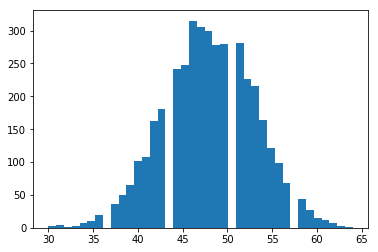

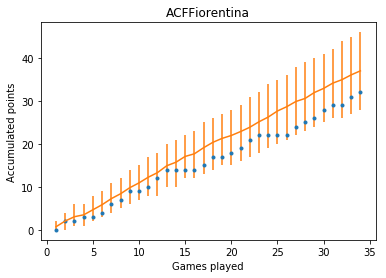

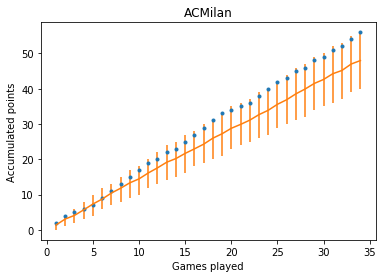

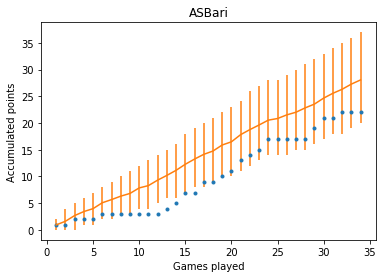

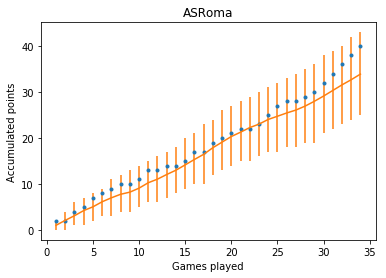

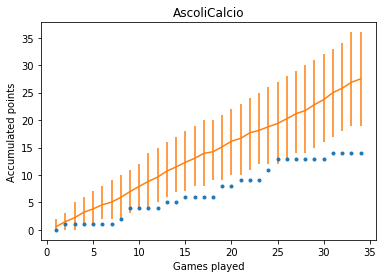

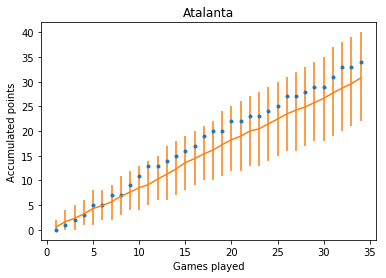

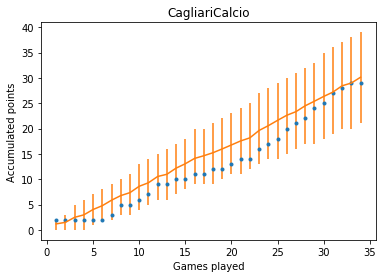

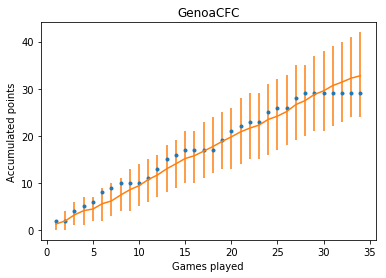

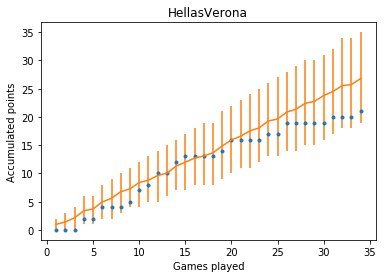

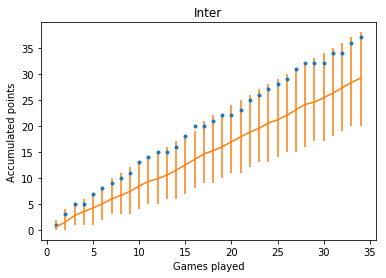

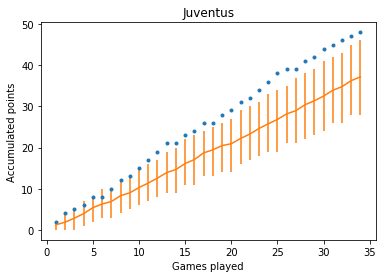

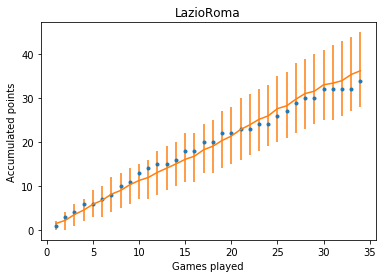

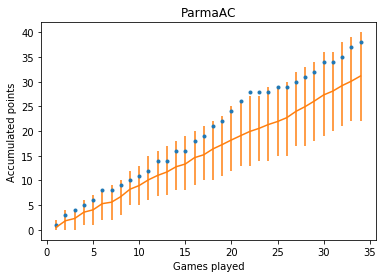

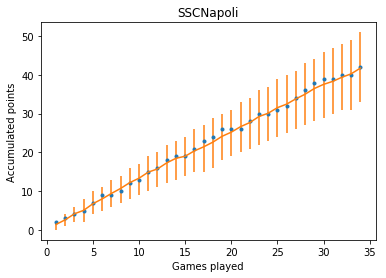

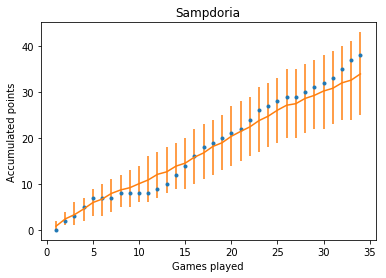

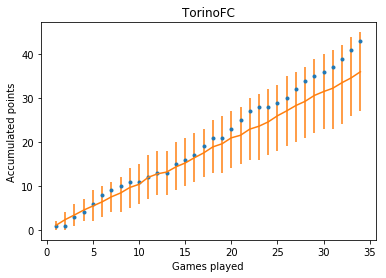

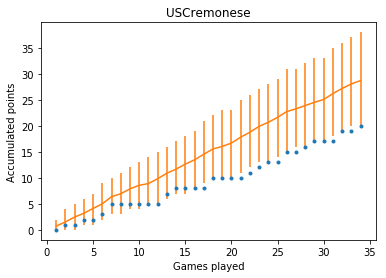

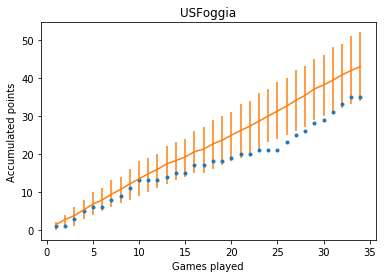

In [9]:
lower_percentile = np.zeros([N_teams, N_games_per_team])
upper_percentile = np.zeros([N_teams, N_games_per_team])
percentage1, percentage2 = 5,95

for i in range(N_teams):
    print(ordered_teams[i])
    print(np.mean(accumulated_points[i,-1,:]))
    for j in range(N_games_per_team):
        lower_percentile[i,j] = np.percentile(accumulated_points[i,j,:],percentage1)
        upper_percentile[i,j] = np.percentile(accumulated_points[i,j,:],percentage2)
teams = np.arange(N_teams)
mean_accumulated_points1 = np.mean(accumulated_points, axis = 2)
errorbar1 = np.empty([2,N_teams, N_games_per_team])
errorbar1[0,:,:] = mean_accumulated_points1 - lower_percentile
errorbar1[1,:,:] = upper_percentile - mean_accumulated_points1
plt.hist(accumulated_points[1,-1,:], bins = 'auto')
plt.show()
for team in teams:
    plt.plot(np.arange(1,35), actual_accumulated_points[team, :], '.', label = 'Actual accumulated points')
    #plt.plot(np.arange(1,35), mean_accumulated_points[team, :], label = 'Predicted mean accumulated points')
    plt.errorbar(np.arange(1,35), mean_accumulated_points1[team, :], errorbar1[:,team,:], label = 'Predicted mean accumulated points')
    plt.xlabel('Games played')
    plt.ylabel('Accumulated points')
    plt.title(ordered_teams[team])
    plt.show()

### Non-hierarchical Poisson Model


In [10]:
#Stan code
stan_code = """
data {
int N; // number of observation points (306 games)
int N_teams; //number of unique teams (18)
int y1[N]; // vector of observed home goals 
int y2[N]; // vector of observed away goals
int h[N]; //indices for home teams
int a[N]; //indices for away teams
}

parameters {
vector[N_teams] att_uncond; // vector of attack values for the 18 teams without sum-to-zero constraint
vector[N_teams] def_uncond; // vector of defence values for the 18 teams without sum-to-zero constraint
real home; //constant home advantage across all teams*
}


transformed parameters {
vector<lower=0>[N] theta1;
vector<lower=0>[N] theta2;
vector[N_teams] att; // vector of attack values for the 18 teams
vector[N_teams] def; // vector of defence values for the 18 teams

for (i in 1:N_teams){
att[i] = att_uncond[i] - mean(att_uncond);
def[i] = def_uncond[i] - mean(def_uncond);
}

for (i in 1:N){
theta1[i] = exp(home + att[h[i]] + def[a[i]]);
theta2[i] = exp(att[a[i]] + def[h[i]]);
}

}


model {

for (i in 1:N_teams){
att_uncond[i] ~ normal(0, 1000);
def_uncond[i] ~ normal(0, 1000);
}

for (i in 1:N){
y1[i] ~ poisson(theta1[i]);
y2[i] ~ poisson(theta2[i]);
}

}


generated quantities {
vector[N] y1_pred;
vector[N] y2_pred;
vector[N] log_lik;
for (i in 1:N){
    log_lik[i] = poisson_lpmf(y1[i] | theta1[i]) + poisson_lpmf(y2[i] | theta2[i]);
    y1_pred[i] = poisson_rng(theta1[i]);
    y2_pred[i] = poisson_rng(theta2[i]);}

}

"""

#Compile Stan code and make fit
sm = pystan.StanModel(model_code=stan_code)
fit = sm.sampling(data=football_data, control={"adapt_delta" : 0.99, "max_treedepth": 20})
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1cca9b792907beba76bafa25e201a406 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_1cca9b792907beba76bafa25e201a406.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
att_uncond[1]  -51.81   32.37 205.04 -393.0 -196.7 -96.11  74.12 438.71     40   1.11
att_uncond[2]  -51.35   32.37 205.05 -392.6 -196.2 -95.65  74.66 439.16     40   1.11
att_uncond[3]  -52.29   32.37 205.04 -393.6 -197.0 -96.57  73.46 438.26     40   1.11
att_uncond[4]  -51.99   32.37 205.04 -393.3 -196.8  -96.3  73.98 438.69     40   1.11
att_uncond[5]   -52.3   32.37 205.04 -393.5 -197.1 -96.59  73.65  438.3     40   1.11
att_uncond[6]  -52.15   32.37 205.05 -393.3 -197.0 -96.45  73.82 438.43     40   1.11
att_uncond[7]  -52.18   32.37 205.04 -393.3 -197.0 -96.49  73.77 438.51     40   1.11
att_uncond[8]  -52.02   32.37 205.04 -393.2 -196.8 -96.34  74.03 438.58     40   1.11
att_uncond[9]  -52.35   32.37 205.05 

In [11]:
log_lik = fit.extract('log_lik')['log_lik']
model2_loo, model2_loos, model2_k = psisloo(log_lik)

#Effective sample size computed based on eq. (7.5) and (7.15) in BDA
S = log_lik.shape[0]
lppd = np.sum(np.log(1/S*np.sum(np.exp(log_lik),axis=0)))
peff = lppd - model2_loo
print(peff)

28.086419972906697


In [12]:
actual_scores = np.zeros([N_teams, N_games_per_team], dtype = int)
actual_accumulated_points = np.zeros([N_teams, N_games_per_team], dtype = int)
count = np.zeros(N_teams, dtype = int)
for j in range(len(y1)):
        points1, points2 = points(y1[j],y2[j])
        count[h[j]-1] = count[h[j]-1] + 1
        count[a[j]-1] = count[a[j]-1] + 1
        actual_scores[h[j]-1, count[h[j]-1]-1] = points1 
        actual_scores[a[j]-1, count[a[j]-1]-1] = points2 
        actual_accumulated_points[h[j]-1, count[h[j]-1]-1] = np.sum(actual_scores[h[j]-1, :])
        actual_accumulated_points[a[j]-1, count[a[j]-1]-1] = np.sum(actual_scores[a[j]-1, :])

In [13]:
#for i in range(N_teams):
#    print(ordered_teams[i])
#    print(actual_accumulated_points[i,-1])

In [14]:
y1_pred = fit.extract('y1_pred')['y1_pred']
y2_pred = fit.extract('y2_pred')['y2_pred']
scores = np.zeros([N_teams, N_games_per_team, y1_pred.shape[0]], dtype = int)
accumulated_points = np.zeros([N_teams, N_games_per_team, y1_pred.shape[0]], dtype = int)


for i in range(y1_pred.shape[0]):
    count = np.zeros(N_teams, dtype = int)
    for j in range(y1_pred.shape[1]):
        points1, points2 = points(y1_pred[i,j],y2_pred[i,j])
        count[h[j]-1] = count[h[j]-1] + 1
        count[a[j]-1] = count[a[j]-1] + 1
        scores[h[j]-1, count[h[j]-1]-1, i] = points1 
        scores[a[j]-1, count[a[j]-1]-1, i] = points2 
        accumulated_points[h[j]-1, count[h[j]-1]-1, i] = np.sum(scores[h[j]-1, :, i])
        accumulated_points[a[j]-1, count[a[j]-1]-1, i] = np.sum(scores[a[j]-1, :, i])

ACFFiorentina
35.18425
ACMilan
53.42225
ASBari
24.72925
ASRoma
36.74125
AscoliCalcio
17.71775
Atalanta
32.89475
CagliariCalcio
32.086
GenoaCFC
28.951
HellasVerona
20.42875
Inter
34.0855
Juventus
44.28875
LazioRoma
35.15075
ParmaAC
35.87775
SSCNapoli
40.17025
Sampdoria
37.33825
TorinoFC
44.2685
USCremonese
24.524
USFoggia
34.141


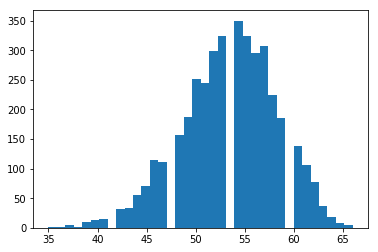

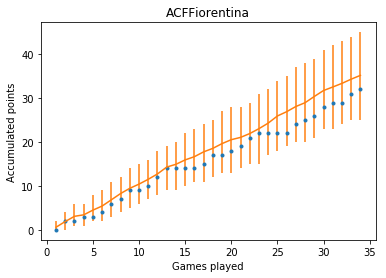

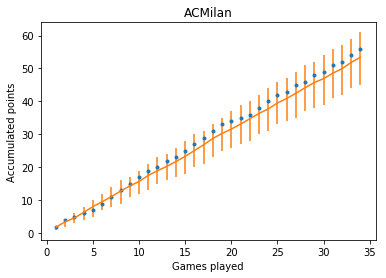

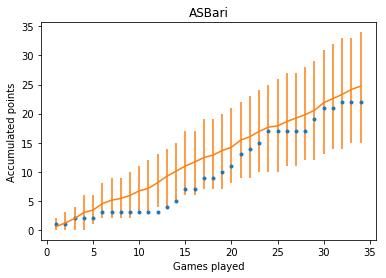

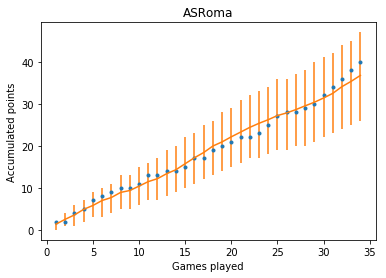

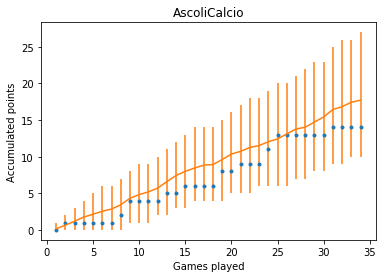

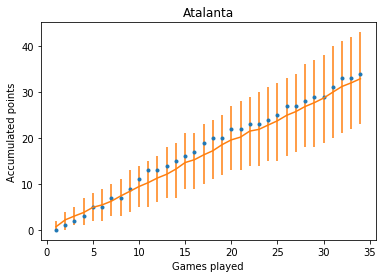

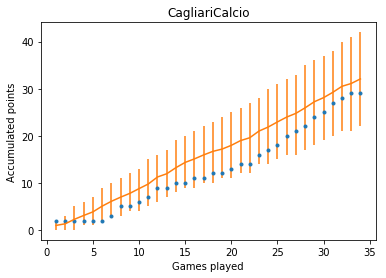

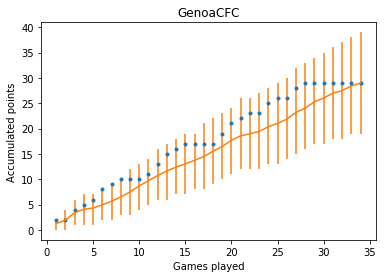

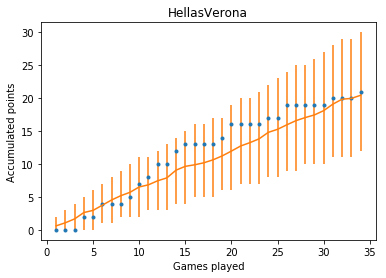

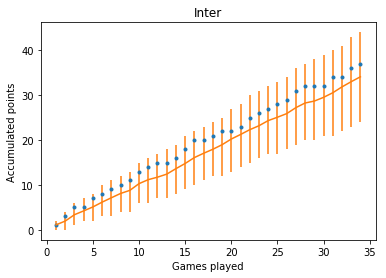

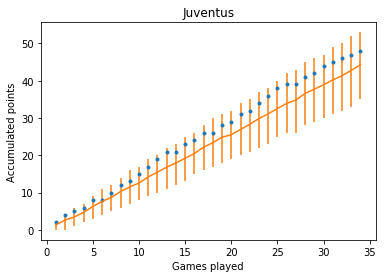

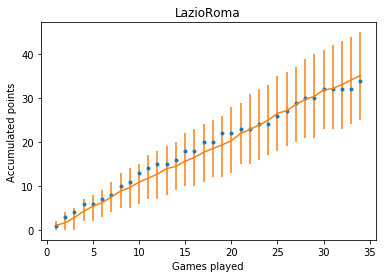

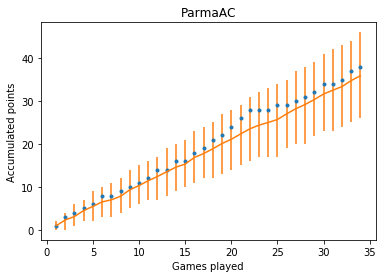

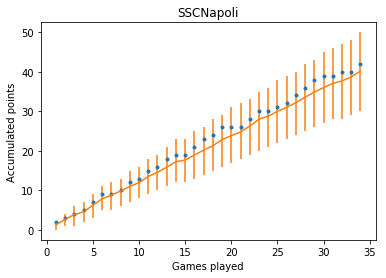

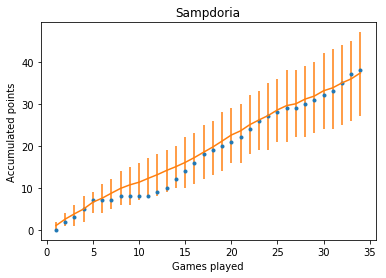

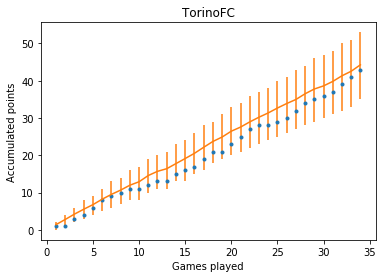

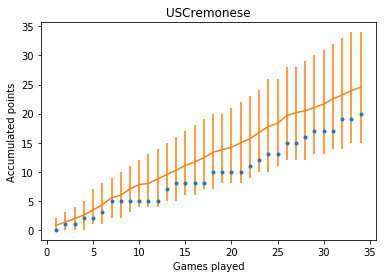

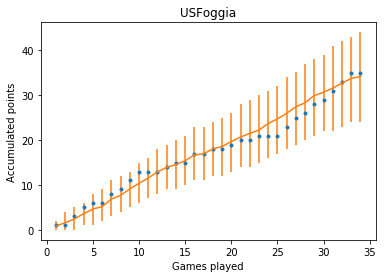

In [15]:
lower_percentile = np.zeros([N_teams, N_games_per_team])
upper_percentile = np.zeros([N_teams, N_games_per_team])
percentage1, percentage2 = 5,95

for i in range(N_teams):
    print(ordered_teams[i])
    print(np.mean(accumulated_points[i,-1,:]))
    for j in range(N_games_per_team):
        lower_percentile[i,j] = np.percentile(accumulated_points[i,j,:],percentage1)
        upper_percentile[i,j] = np.percentile(accumulated_points[i,j,:],percentage2)
teams = np.arange(N_teams)
mean_accumulated_points2 = np.mean(accumulated_points, axis = 2)
errorbar2 = np.empty([2,N_teams, N_games_per_team])
errorbar2[0,:,:] = mean_accumulated_points2 - lower_percentile
errorbar2[1,:,:] = upper_percentile - mean_accumulated_points2
plt.hist(accumulated_points[1,-1,:], bins = 'auto')
plt.show()
for team in teams:
    plt.plot(np.arange(1,35), actual_accumulated_points[team, :], '.', label = 'Actual accumulated points')
    #plt.plot(np.arange(1,35), mean_accumulated_points[team, :], label = 'Predicted mean accumulated points')
    plt.errorbar(np.arange(1,35), mean_accumulated_points2[team, :], errorbar2[:,team,:], label = 'Predicted mean accumulated points')
    plt.xlabel('Games played')
    plt.ylabel('Accumulated points')
    plt.title(ordered_teams[team])
    plt.show()

### Hierarchical Poisson Model

In [16]:
#Stan code
stan_code = """
data {
int N; // number of observation points (306 games)
int N_teams; //number of unique teams (18)
int y1[N]; // vector of observed home goals 
int y2[N]; // vector of observed away goals
int h[N]; //indices for home teams
int a[N]; //indices for away teams
}

parameters {
vector[N_teams] att_uncond; // vector of attack values for the 18 teams without sum-to-zero constraint
vector[N_teams] def_uncond; // vector of defence values for the 18 teams without sum-to-zero constraint
real home; //constant home advantage across all teams
real mu_att;
real<lower=0> sigma_att;
real mu_def;
real<lower=0> sigma_def;
}


transformed parameters {
vector<lower=0>[N] theta1;
vector<lower=0>[N] theta2;
vector[N_teams] att; // vector of attack values for the 18 teams
vector[N_teams] def; // vector of defence values for the 18 teams

for (i in 1:N_teams){
att[i] = att_uncond[i] - mean(att_uncond);
def[i] = def_uncond[i] - mean(def_uncond);
}

for (i in 1:N){
theta1[i] = exp(home + att[h[i]] + def[a[i]]);
theta2[i] = exp(att[a[i]] + def[h[i]]);
}

}


model {

home ~ normal(0, 10000);
mu_att ~ normal(0, 10000);
sigma_att ~ gamma(0.1, 0.1);
mu_def ~ normal(0, 10000);
sigma_def ~ gamma(0.1,0.1);

for (i in 1:N_teams){
att_uncond[i] ~ normal(mu_att, sigma_att);
def_uncond[i] ~ normal(mu_def, sigma_def);
}

for (i in 1:N){
y1[i] ~ poisson(theta1[i]);
y2[i] ~ poisson(theta2[i]);
}

}


generated quantities {
vector[N] y1_pred;
vector[N] y2_pred;
vector[N] log_lik;
for (i in 1:N){
    log_lik[i] = poisson_lpmf(y1[i] | theta1[i]) + poisson_lpmf(y2[i] | theta2[i]);
    y1_pred[i] = poisson_rng(theta1[i]);
    y2_pred[i] = poisson_rng(theta2[i]);}


}

"""

#Compile Stan code and make fit
sm = pystan.StanModel(model_code=stan_code)
fit = sm.sampling(data=football_data, control={"adapt_delta" : 0.99, "max_treedepth": 15})
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_95c4575c91359f85f30383b7a931af4c NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_95c4575c91359f85f30383b7a931af4c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
att_uncond[1]  1125.8  646.56 1095.7  -51.9 319.64 512.37 1597.7 3739.3      3    3.7
att_uncond[2]  1126.2  646.56 1095.7 -51.51 319.95 512.67 1598.3 3739.8      3    3.7
att_uncond[3]  1125.5  646.56 1095.7 -52.28 319.24 512.07 1597.4 3739.0      3    3.7
att_uncond[4]  1125.7  646.56 1095.7 -52.12 319.38 512.16 1597.6 3739.3      3    3.7
att_uncond[5]  1125.5  646.56 1095.7 -52.23 319.18 512.04 1597.4 3739.0      3    3.7
att_uncond[6]  1125.6  646.56 1095.7 -52.18  319.3 512.18 1597.5 3739.1      3    3.7
att_uncond[7]  1125.6  646.56 1095.7 -52.22  319.2 512.13 1597.5 3739.0      3    3.7
att_uncond[8]  1125.7  646.56 1095.7  -52.1 319.38 512.22 1597.6 3739.3      3    3.7
att_uncond[9]  1125.5  646.56 1095.7 

In [17]:
log_lik = fit.extract('log_lik')['log_lik']
model3_loo, model3_loos, model3_k = psisloo(log_lik)

#Effective sample size computed based on eq. (7.5) and (7.15) in BDA
S = log_lik.shape[0]
lppd = np.sum(np.log(1/S*np.sum(np.exp(log_lik),axis=0)))
peff = lppd - model3_loo
print(peff)

22.173474023215704


In [18]:
actual_scores = np.zeros([N_teams, N_games_per_team], dtype = int)
actual_accumulated_points = np.zeros([N_teams, N_games_per_team], dtype = int)
count = np.zeros(N_teams, dtype = int)
for j in range(len(y1)):
        points1, points2 = points(y1[j],y2[j])
        count[h[j]-1] = count[h[j]-1] + 1
        count[a[j]-1] = count[a[j]-1] + 1
        actual_scores[h[j]-1, count[h[j]-1]-1] = points1 
        actual_scores[a[j]-1, count[a[j]-1]-1] = points2 
        actual_accumulated_points[h[j]-1, count[h[j]-1]-1] = np.sum(actual_scores[h[j]-1, :])
        actual_accumulated_points[a[j]-1, count[a[j]-1]-1] = np.sum(actual_scores[a[j]-1, :])

In [19]:
#for i in range(N_teams):
#    print(ordered_teams[i])
#    print(actual_accumulated_points[i,-1])


In [20]:
y1_pred = fit.extract('y1_pred')['y1_pred']
y2_pred = fit.extract('y2_pred')['y2_pred']
scores = np.zeros([N_teams, N_games_per_team, y1_pred.shape[0]], dtype = int)
accumulated_points = np.zeros([N_teams, N_games_per_team, y1_pred.shape[0]], dtype = int)


for i in range(y1_pred.shape[0]):
    count = np.zeros(N_teams, dtype = int)
    for j in range(y1_pred.shape[1]):
        points1, points2 = points(y1_pred[i,j],y2_pred[i,j])
        count[h[j]-1] = count[h[j]-1] + 1
        count[a[j]-1] = count[a[j]-1] + 1
        scores[h[j]-1, count[h[j]-1]-1, i] = points1 
        scores[a[j]-1, count[a[j]-1]-1, i] = points2 
        accumulated_points[h[j]-1, count[h[j]-1]-1, i] = np.sum(scores[h[j]-1, :, i])
        accumulated_points[a[j]-1, count[a[j]-1]-1, i] = np.sum(scores[a[j]-1, :, i])

ACFFiorentina
35.09825
ACMilan
50.26775
ASBari
26.93475
ASRoma
36.2045
AscoliCalcio
20.30175
Atalanta
33.4455
CagliariCalcio
32.71575
GenoaCFC
29.77075
HellasVerona
23.09675
Inter
34.153
Juventus
41.969
LazioRoma
34.94825
ParmaAC
35.453
SSCNapoli
39.0765
Sampdoria
36.41925
TorinoFC
41.85575
USCremonese
26.55325
USFoggia
33.73625


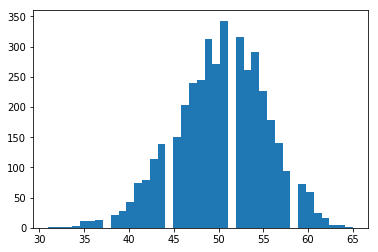

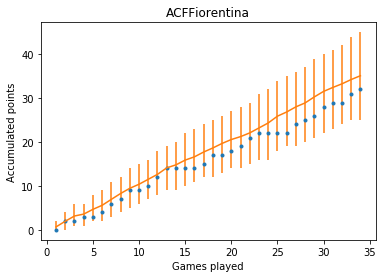

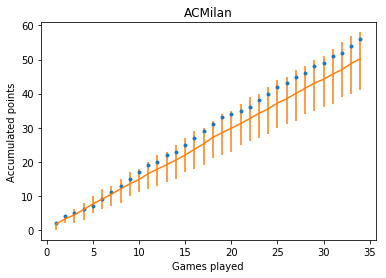

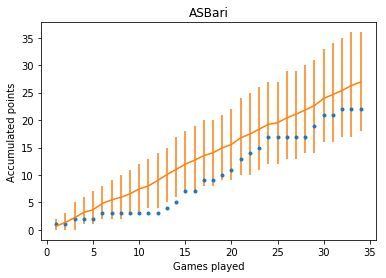

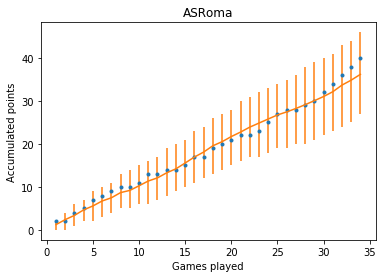

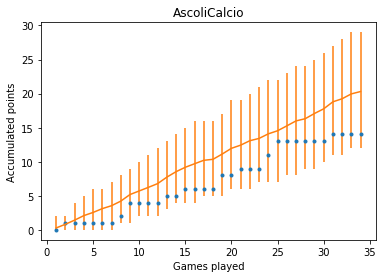

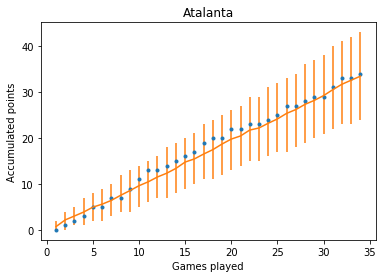

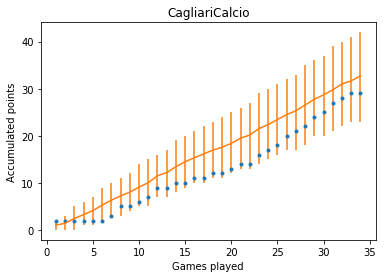

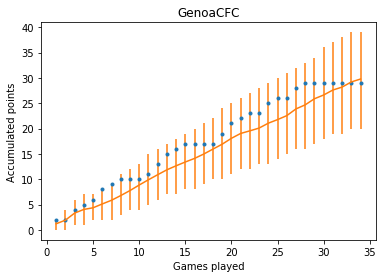

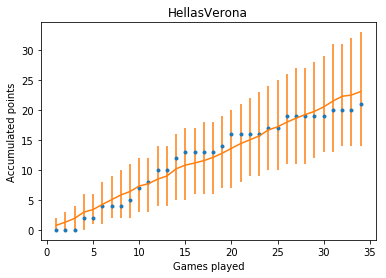

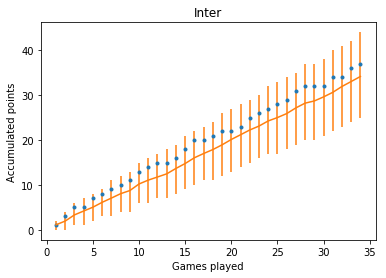

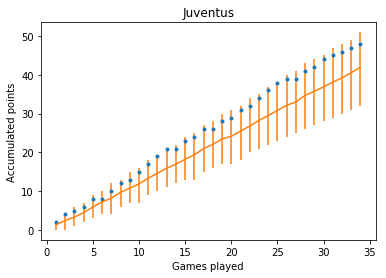

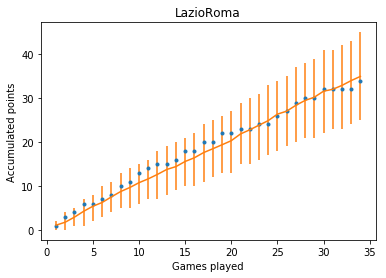

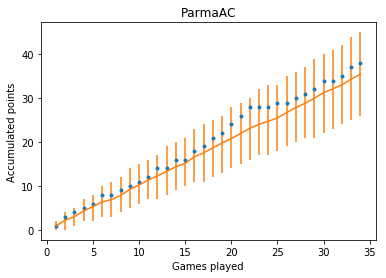

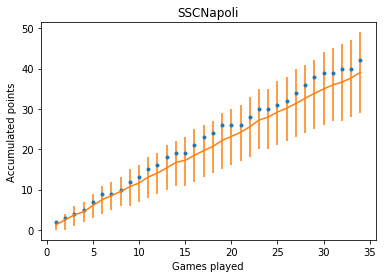

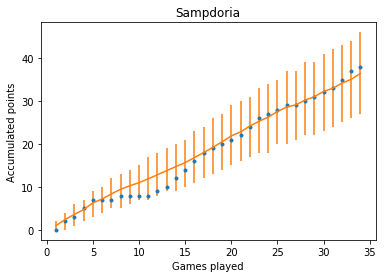

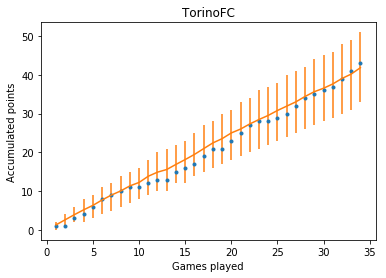

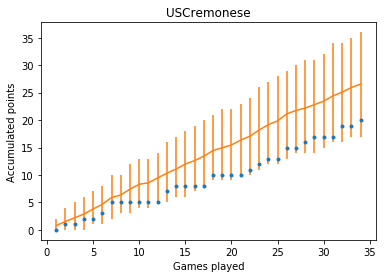

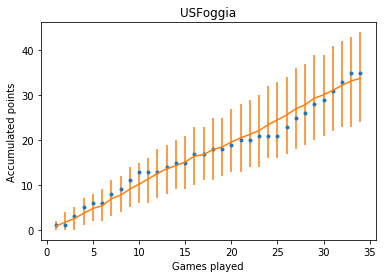

In [21]:
lower_percentile = np.zeros([N_teams, N_games_per_team])
upper_percentile = np.zeros([N_teams, N_games_per_team])
percentage1, percentage2 = 5,95

for i in range(N_teams):
    print(ordered_teams[i])
    print(np.mean(accumulated_points[i,-1,:]))
    for j in range(N_games_per_team):
        lower_percentile[i,j] = np.percentile(accumulated_points[i,j,:],percentage1)
        upper_percentile[i,j] = np.percentile(accumulated_points[i,j,:],percentage2)
teams = np.arange(N_teams)
mean_accumulated_points3 = np.mean(accumulated_points, axis = 2)
errorbar3 = np.empty([2,N_teams, N_games_per_team])
errorbar3[0,:,:] = mean_accumulated_points3 - lower_percentile
errorbar3[1,:,:] = upper_percentile - mean_accumulated_points3
plt.hist(accumulated_points[1,-1,:], bins = 'auto')
plt.show()
for team in teams:
    plt.plot(np.arange(1,35), actual_accumulated_points[team, :], '.', label = 'Actual accumulated points')
    #plt.plot(np.arange(1,35), mean_accumulated_points[team, :], label = 'Predicted mean accumulated points')
    plt.errorbar(np.arange(1,35), mean_accumulated_points3[team, :], errorbar3[:,team,:], label = 'Predicted mean accumulated points')
    plt.xlabel('Games played')
    plt.ylabel('Accumulated points')
    plt.title(ordered_teams[team])
    plt.show()

### Analysis of PSIS-LOO values

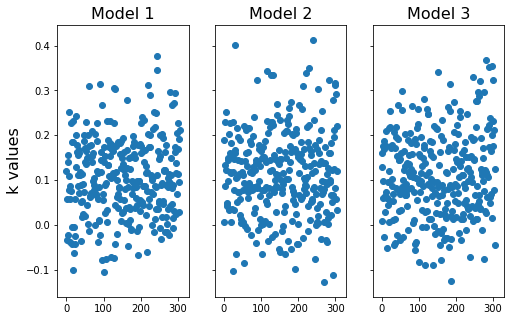

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(8,5), sharex=True, sharey=True)
axes[0].scatter(range(len(model3_k)), model3_k)
axes[0].set_title("Model 1", FontSize = 16)
axes[0].set_ylabel('k values', FontSize = 16)
axes[1].scatter(range(len(model2_k)), model2_k)
axes[1].set_title("Model 2", FontSize = 16)
axes[2].scatter(range(len(model1_k)), model1_k)
_ = axes[2].set_title("Model 3", FontSize = 16)
fig.savefig('k-values.png')

In [27]:
print(model3_loo, model2_loo, model1_loo)

-805.100525942071 -808.4369956066548 -839.1542005272445


In [24]:
att = fit.extract('def')['def']
print(np.mean(att, axis=0), ordered_teams)

[ 0.07188314 -0.33338765  0.16625768 -0.1337369   0.47380728 -0.09511177
 -0.07277897  0.17347218  0.31939347 -0.20067771 -0.32730579  0.054675
 -0.19993682  0.06677124 -0.13135518 -0.39086449  0.19862153  0.36027376] ['ACFFiorentina', 'ACMilan', 'ASBari', 'ASRoma', 'AscoliCalcio', 'Atalanta', 'CagliariCalcio', 'GenoaCFC', 'HellasVerona', 'Inter', 'Juventus', 'LazioRoma', 'ParmaAC', 'SSCNapoli', 'Sampdoria', 'TorinoFC', 'USCremonese', 'USFoggia']


### Comparison of model predictions

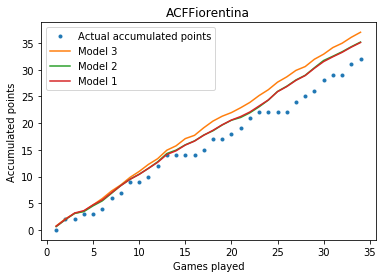

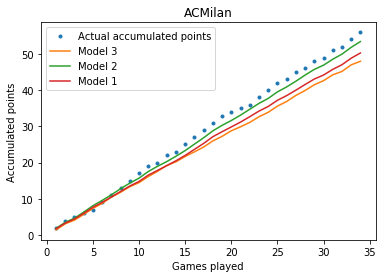

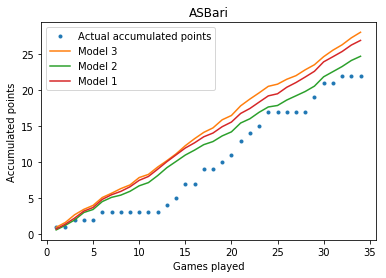

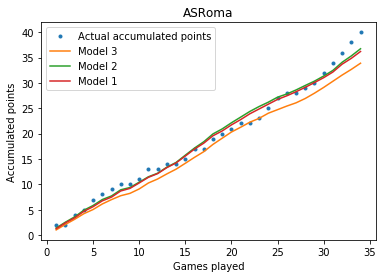

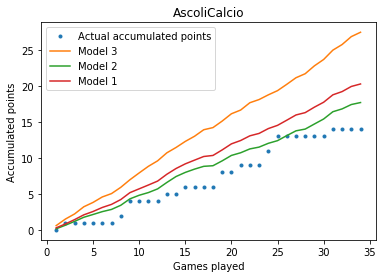

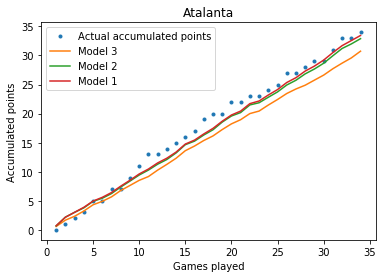

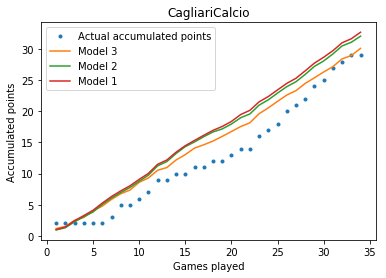

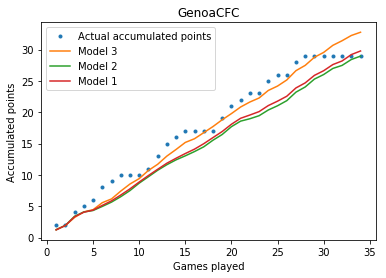

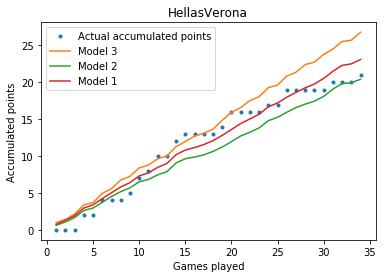

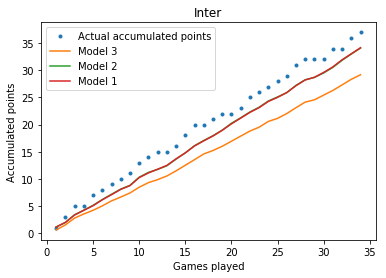

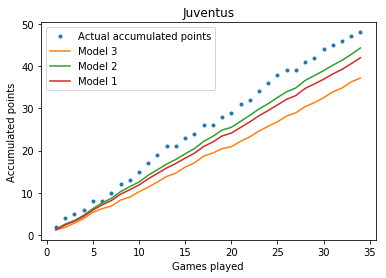

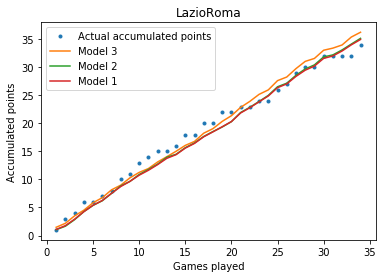

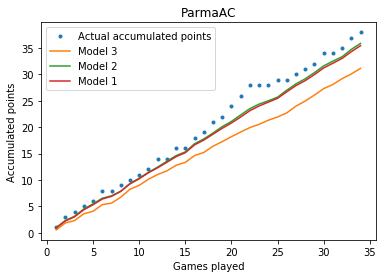

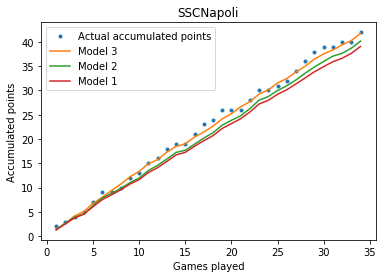

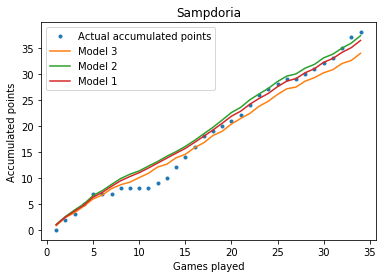

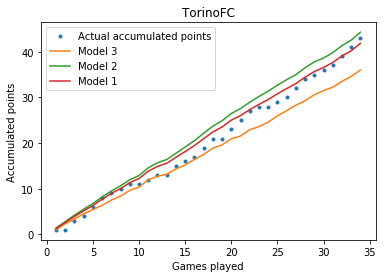

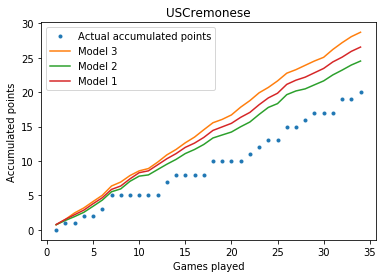

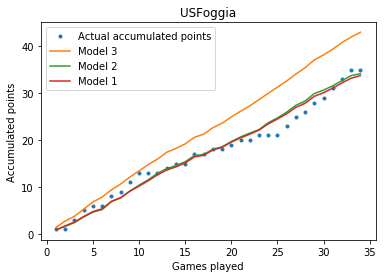

In [25]:
teams = np.arange(N_teams)
for team in teams:
    plt.plot(np.arange(1,35), actual_accumulated_points[team, :], '.', label = 'Actual accumulated points')
    plt.plot(np.arange(1,35), mean_accumulated_points1[team, :], label = 'Model 3')
    plt.plot(np.arange(1,35), mean_accumulated_points2[team, :], label = 'Model 2')
    plt.plot(np.arange(1,35), mean_accumulated_points3[team, :], label = 'Model 1')
    #plt.errorbar(np.arange(1,35), mean_accumulated_points1[team, :], errorbar1[:,team,:], label = 'Model 3')
    #plt.errorbar(np.arange(1,35), mean_accumulated_points2[team, :], errorbar2[:,team,:], label = 'Model 2')
    #plt.errorbar(np.arange(1,35), mean_accumulated_points3[team, :], errorbar3[:,team,:], label = 'Model 1')
    plt.xlabel('Games played')
    plt.ylabel('Accumulated points')
    plt.legend()
    plt.title(ordered_teams[team])
    plt.savefig('{}.png'.format(ordered_teams[team]))
    plt.show()